In [ ]:
# connect to google colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout, Lambda, Input, GlobalAveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
# from keras import regularizers
from tensorflow.keras.models import Model

from IPython.display import display, Image
import time

from tensorflow.keras.applications import Xception

In [ ]:
# can add the colab filepath here
# change colab flag to false if train using jupyter notebook
COLAB_FLAG = True

COLAB_FILEPATH = './drive/My Drive/4041-dog-breed-classification/' if COLAB_FLAG == True else './'
%matplotlib inline

In [ ]:
#reading labels csv file

labels = pd.read_csv(COLAB_FILEPATH+'Datasets/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# describing the data
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,8e3b7695d93b91002370bdc9d01bfcfb,scottish_deerhound
freq,1,126


In [ ]:
# total unique breeds
labels['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

In [ ]:
# create a list store the dog breed classes
# create dictionary of unique breeds with its respective id
breeds = labels.breed.unique()
dict_breeds = dict(zip(breeds, range(len(breeds))))

# add duplicate column
labels["breed_id"] = labels.breed
# convert duplicated column as unique id
labels = labels.replace({"breed_id":dict_breeds})

print("Shape\t\t: {}".format(labels.shape))
print("Unique labels\t: {}".format(len(breeds)))

Shape		: (10222, 3)
Unique labels	: 120


### ONLY IF RAW IMAGE FILE IS PRESENT THEN CAN EXECUTE THIS

In [ ]:
# check the display of one image from the train set
#Image(COLAB_FILEPATH+"Datasets/train/00a338a92e4e7bf543340dc849230e75.jpg")

In [ ]:
# double check if number of images match with the number of labels
#len(os.listdir(COLAB_FILEPATH+'Datasets/train/')) == len(labels['id'])

### --- END ---

In [ ]:
labels.head()

,id,breed,breed_id
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,0
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,1
2,001cdf01b096e06d78e9e5112d419397,pekinese,2
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,3
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,4


In [ ]:
dict_breeds

{'affenpinscher': 24,
 'afghan_hound': 74,
 'african_hunting_dog': 13,
 'airedale': 63,
 'american_staffordshire_terrier': 68,
 'appenzeller': 46,
 'australian_terrier': 42,
 'basenji': 7,
 'basset': 41,
 'beagle': 95,
 'bedlington_terrier': 5,
 'bernese_mountain_dog': 67,
 'black-and-tan_coonhound': 22,
 'blenheim_spaniel': 110,
 'bloodhound': 47,
 'bluetick': 3,
 'border_collie': 53,
 'border_terrier': 33,
 'borzoi': 6,
 'boston_bull': 0,
 'bouvier_des_flandres': 115,
 'boxer': 17,
 'brabancon_griffon': 80,
 'briard': 91,
 'brittany_spaniel': 50,
 'bull_mastiff': 66,
 'cairn': 23,
 'cardigan': 70,
 'chesapeake_bay_retriever': 92,
 'chihuahua': 58,
 'chow': 82,
 'clumber': 72,
 'cocker_spaniel': 118,
 'collie': 55,
 'curly-coated_retriever': 106,
 'dandie_dinmont': 93,
 'dhole': 31,
 'dingo': 1,
 'doberman': 18,
 'english_foxhound': 87,
 'english_setter': 27,
 'english_springer': 117,
 'entlebucher': 54,
 'eskimo_dog': 78,
 'flat-coated_retriever': 83,
 'french_bulldog': 114,
 'german

In [ ]:
# initialise the input shape
INPUT_SHAPE = (128,128,3)

### --- Code to convert image to numpy array ---

In [ ]:
# one-hot encoding and transform images to array
def to_numpy_array_train(train_path, labels_df, img_size):
    image_labels = labels_df['breed']
    X = np.zeros([len(labels_df), img_size[0], img_size[1], img_size[2]], dtype=np.float16) # float16 takes less memory
    y = np.zeros([len(labels_df), 1], dtype=np.float16)
    for idx, img_name in enumerate(tqdm(labels_df['id'].values)):
        img_dir = train_path+img_name+'.jpg'
        img = load_img(img_dir,target_size=img_size)
        X[idx] = img
        X[idx] /= 255.0
        del img
        dog_breed = image_labels[idx]
        y[idx] = dict_breeds[dog_breed]
    y = to_categorical(y)
    
    return X,y

In [ ]:
# check the timing of the load images function
t = time.time()
X,y = to_numpy_array_train(COLAB_FILEPATH+'Datasets/train/', labels, INPUT_SHAPE)

print(f'Time taken to load images: {time.time()-t}')

In [ ]:
X.shape

(10222, 128, 128, 3)

In [ ]:
y.shape

(10222, 120)

In [ ]:
# save the numpy array of both the images array and the labels array
np.savez_compressed(COLAB_FILEPATH+'Datasets/X.npz',X)
np.savez_compressed(COLAB_FILEPATH+'Datasets/y.npz',y)

### --- END ---

In [ ]:
# loading the numpy array back
X_ = np.load(COLAB_FILEPATH+'Datasets/X.npz')
X = X_['arr_0']
y_ = np.load(COLAB_FILEPATH+'Datasets/y.npz')
y = y_['arr_0']

In [ ]:
X.shape

(10222, 128, 128, 3)

In [ ]:
y.shape

(10222, 120)

In [ ]:
# check the numpy array values whether is it normalised or not
X[50][0][:7]

array([[0.6157, 0.565 , 0.498 ],
       [0.4158, 0.3647, 0.298 ],
       [0.306 , 0.251 , 0.2   ],
       [0.2354, 0.1843, 0.149 ],
       [0.2313, 0.1804, 0.1569],
       [0.4158, 0.3608, 0.349 ],
       [0.2235, 0.2079, 0.1647]], dtype=float16)

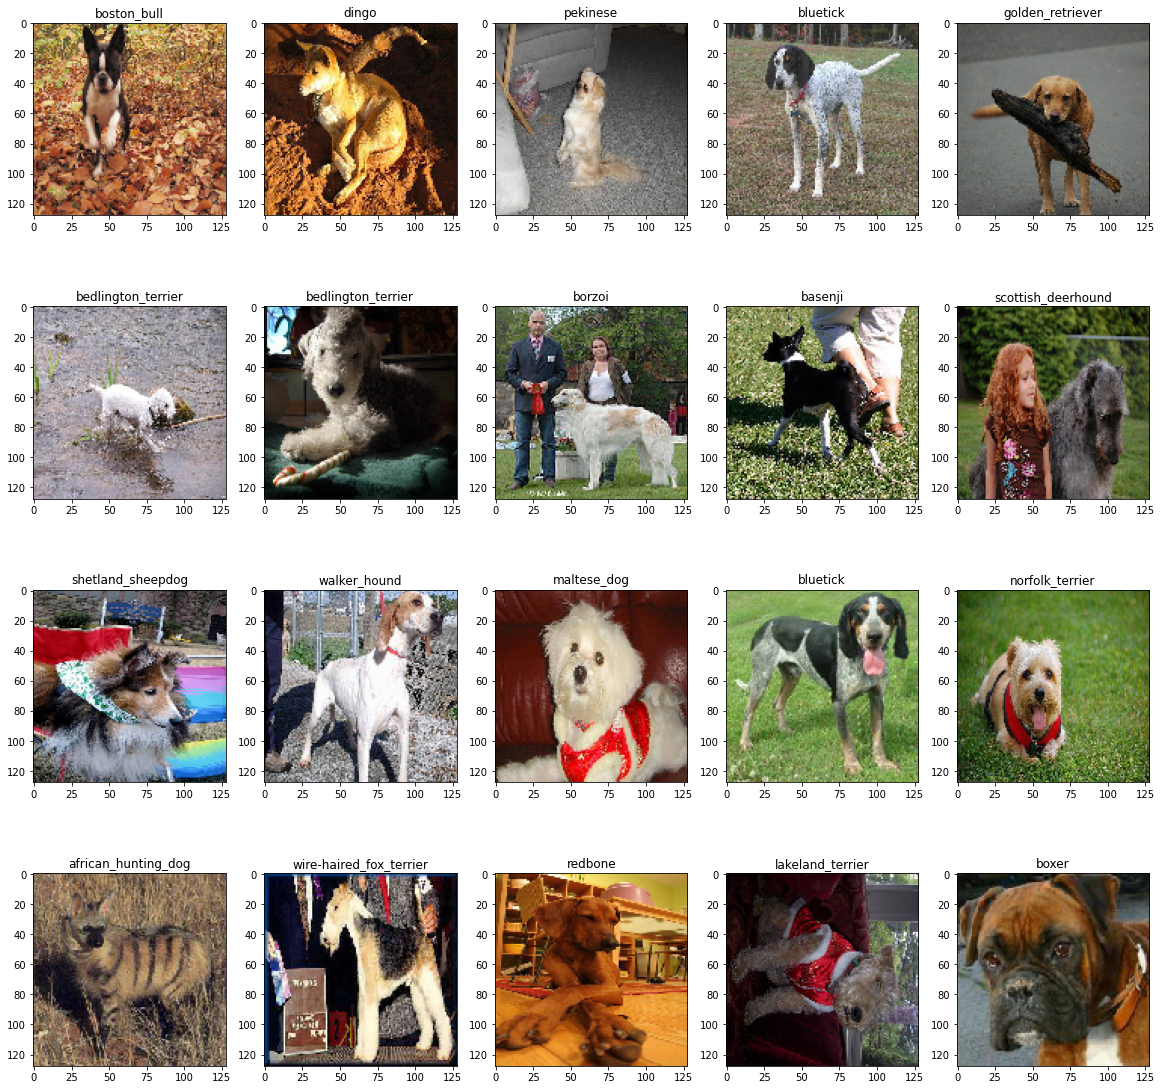

In [ ]:
# check the data
N = 20

plt.figure(figsize=(20,20))
for i in range(N):
    ax = plt.subplot(int(N/5),5,i+1)
    plt.title(breeds[np.where(y[i]==1)[0][0]])
    plt.imshow(X[i].astype('float32'))

### SPLIT DATA INTO TRAIN AND VAL

In [ ]:
# perform train test split to get training and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8,random_state=42)

## Image Augmentation

In [ ]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    #rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = "nearest"
)

# this is the augmentation configuration we will use for testing:
# only rescaling
#test_datagen = ImageDataGenerator(rescale=1./255)

## Model Building

In [ ]:
# for plotting
def plot_model_history(history, folder=COLAB_FILEPATH+"plots/", saving_name="model_loss_accuracy"):
    plt.style.use("ggplot")
    plt.figure(figsize=(16, 6))

    # plot for loss
    ax = plt.subplot(1, 2, 1)
    # ensure ploting never plot beyond 10
    #y_max = (max(history.history["loss"]), max(history.history["val_loss"]))
    #y_max = min(10.0, max(y_max))
    #ax.set_ylim(ymax=y_max)
    plt.plot( history.history["loss"], label="train_loss")
    plt.plot( history.history["val_loss"], label="val_loss")
    plt.title("Model Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    # plot for accuracy
    ax = plt.subplot(1, 2, 2)
    ax.set_ylim([0,1]) # fix y-range for eazy comparison 
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")

    plt.title("Model Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

    # save plot to disk
    os.makedirs(os.path.dirname(folder), exist_ok=True)
    plt.savefig(folder+saving_name)
    plt.show()

def plot_learning_rate(history, folder="plots/", saving_name="model_learn_rate"):
    # history only contain lr when lrScheduler used 
    #assert('lr' in history.history.keys()), "model history does not contain lr, ensure lr related callback is used"
    
    # the learning rate schedule
    plt.style.use("ggplot")
    plt.figure(figsize=(8, 6))
    plt.plot( history.history["lr"], label="learn rate")
    plt.title("Learning Rate")
    plt.xlabel("Epoch #")
    plt.ylabel("Learning Rate")
    # save plot to disk
    os.makedirs(os.path.dirname(folder), exist_ok=True)
    plt.savefig(folder+saving_name)
    plt.show()

In [ ]:
# hyperparameters
BATCH_SIZE = 128
EPOCHS = 50
ALPHA = 0.001
sgd = SGD(lr=ALPHA,momentum=0.9)
adam = Adam(lr=ALPHA, beta_1=0.9, beta_2=0.999)

In [ ]:
# initialise saved weights filename
FILENAME = 'xception_test_weights'

In [ ]:
# define callbacks
saved_weights = ModelCheckpoint(filepath=f'{COLAB_FILEPATH}Datasets/{FILENAME}.h5',save_best_only=True,verbose=1)
reduced_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# image size
IMG_SIZE = (128,128,3)

In [ ]:
# retrieve base model
base = Xception(include_top=False, weights='imagenet', input_shape=IMG_SIZE)

# freeze pre-trained weight
# base.trainable = False

# rebuild output layer
x = base.output
x = GlobalAveragePooling2D()(x)
head = Dense(120, activation='softmax')(x)
model = Model(inputs=base.input, outputs=head)
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
_____________________________

In [ ]:
# Compiling the model
model.compile(optimizer=adam, 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
# train model
H = model.fit(train_datagen.flow(X_train,y_train,
                                 batch_size=BATCH_SIZE,
                                 #seed=4041,
                                 shuffle=True),
              epochs=EPOCHS,
              steps_per_epoch=X_train.shape[0]//BATCH_SIZE,
              validation_data=(X_val,y_val),
              callbacks=[saved_weights, reduced_lr, early_stopping]
              )

Epoch 1/50
63/63 [==============================] - 60s 761ms/step - loss: 3.8243 - accuracy: 0.1670 - val_loss: 3.8319 - val_accuracy: 0.2352

Epoch 00001: val_loss improved from inf to 3.83185, saving model to ./drive/My Drive/4041-dog-breed-classification/Datasets/xception_test_weights.h5
Epoch 2/50
63/63 [==============================] - 46s 725ms/step - loss: 1.5816 - accuracy: 0.5560 - val_loss: 3.8073 - val_accuracy: 0.2362

Epoch 00002: val_loss improved from 3.83185 to 3.80727, saving model to ./drive/My Drive/4041-dog-breed-classification/Datasets/xception_test_weights.h5
Epoch 3/50
63/63 [==============================] - 47s 747ms/step - loss: 1.0624 - accuracy: 0.6907 - val_loss: 3.3196 - val_accuracy: 0.3027

Epoch 00003: val_loss improved from 3.80727 to 3.31963, saving model to ./drive/My Drive/4041-dog-breed-classification/Datasets/xception_test_weights.h5
Epoch 4/50
63/63 [==============================] - 48s 752ms/step - loss: 0.7238 - accuracy: 0.7887 - val_loss: 

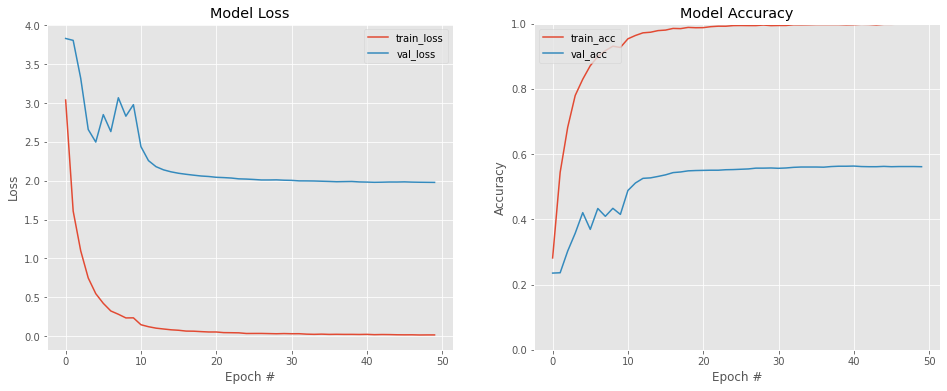

In [ ]:
# plot model performance
plot_model_history(H, saving_name="Xception_freezed")